### P1. Data analysis and preprocessing
*   Comment whether it is possible to include derived features (ratios, flags, mapping, etc.) and append Analytics Base Table (ABT) if needed. 
*   Perform data preprocessing actions if You think it is necessary


In [1]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 

In [2]:
apartment_for_rent_classified = fetch_ucirepo(id=555) 

data_features = pd.DataFrame(apartment_for_rent_classified.data.features)
variables = pd.DataFrame(apartment_for_rent_classified.variables)
metadata = apartment_for_rent_classified.metadata

/Users/p997bjd/uniproj/ai/lab1/venv/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


*   Determine data types of features.

In [3]:
data_types = variables[variables['role'] == 'Feature'][['name', 'type']]
# categorical_features = data_features[data_types[data_types['type'] == 'Categorical']['name']]
# integer_features = data_features[data_types[data_types['type'] == 'Integer']['name']]
# column types looked incorrect therefore I will use the following code to determine the column types
categorical_columns = []
integer_columns = []

for column in data_features.columns:
    first_value = data_features[column].dropna().values[0]
    try:
        float(first_value)
        integer_columns.append(column)
    except ValueError:
        if isinstance(first_value, str):
            categorical_columns.append(column)

columns_to_move = ['price_display']
for column in columns_to_move:
    if column in integer_columns:
        integer_columns.remove(column)
        categorical_columns.append(column)

*   Provide data quality report for all features (analyze categorical and continuous features separately). The form of the report is given in slides (Input Analysis).

In [4]:
continuous_features = data_features[integer_columns].copy()
def ensureNumeric(df):
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors='coerce')
    return df

# Ensure continuous_features contains only numeric data
continuous_features = ensureNumeric(continuous_features)
continuous_summary = continuous_features.describe().T
continuous_summary['% Missing rows'] = continuous_features.isnull().mean() * 100
continuous_summary['Cardinality'] = continuous_features.nunique()
continuous_summary = continuous_summary.rename(columns={
    'count': 'Count',
    'min': 'Min',
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3',
    'max': 'Max',
    'mean': 'Mean',
    'std': 'Standard Deviation'
})
continuous_summary = continuous_summary[['Count', '% Missing rows', 'Cardinality', 'Min', 'Q1', 'Mean', 'Median', 'Q3', 'Max', 'Standard Deviation']]
pd.options.display.float_format = '{:.4f}'.format
print(continuous_summary)


                 Count  % Missing rows  Cardinality             Min  \
bathrooms   99757.0000          0.0691           16          1.0000   
bedrooms    99696.0000          0.1302           10          0.0000   
price       99821.0000          0.0050         3691        100.0000   
square_feet 99821.0000          0.0050         2540         37.6249   
latitude    99797.0000          0.0291         7215         19.5738   
longitude   99795.0000          0.0311         7272       -159.3698   
time        99820.0000          0.0060        75541 1544174418.0000   

                         Q1            Mean          Median              Q3  \
bathrooms            1.0000          1.4453          1.0000          2.0000   
bedrooms             1.0000          1.7280          2.0000          2.0000   
price             1014.0000       1527.2085       1350.0000       1795.0000   
square_feet        729.0000        956.4025        900.0000       1115.0000   
latitude            33.7496      314

In [5]:
categorical_features = data_features[categorical_columns]

categorical_summary = categorical_features.describe(include='all').T
categorical_summary['% Missing rows'] = categorical_features.isnull().mean() * 100
categorical_summary['Cardinality'] = categorical_features.nunique()
categorical_summary['Mode'] = categorical_features.mode().iloc[0] 
categorical_summary['Mode Freq'] = categorical_features.apply(lambda x: x.value_counts().iloc[0])
categorical_summary['Mode %'] = categorical_summary['Mode Freq'] / len(categorical_features) * 100
categorical_summary['2nd Mode'] = categorical_features.apply(lambda x: x.value_counts().index[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode Freq'] = categorical_features.apply(lambda x: x.value_counts().iloc[1] if len(x.value_counts()) > 1 else 0)
categorical_summary['2nd Mode %'] = categorical_summary['2nd Mode Freq'] / len(categorical_features) * 100
# = categorical_summary.fillna(0)
categorical_summary = categorical_summary.infer_objects(copy=False)
# categorical_summary = categorical_summary[['Count', '% Missing rows', 'Cardinality', 'Mode', 'Mode Freq', 'Mode %', '2nd Mode', '2nd Mode Freq', '2nd Mode %']]
print(categorical_summary)

               count  unique  \
category       99826      10   
title          99826   58660   
body           99826   94806   
amenities      83749    9843   
currency       99822       3   
fee            99823       5   
has_photo      99823       6   
pets_allowed   39192       6   
price_type     99823       6   
address         7946    7774   
cityname       99521    2984   
state          99521      53   
source         99820      25   
price_display  99820    4546   

                                                             top   freq  \
category                                  housing/rent/apartment  99762   
title                                Apartment in great location   1066   
body           When searching for a pet-friendly One-, Two- a...     45   
amenities                                                Parking   6204   
currency                                                     USD  99820   
fee                                                           No  996

* clean up some records

In [6]:
trimmed_data_features = data_features[data_features['currency'] == 'USD']
trimmed_data_features = trimmed_data_features.dropna(subset=['price'])
continuous_features = trimmed_data_features[integer_columns]
categorical_features = trimmed_data_features[categorical_columns]

continuous_features = ensureNumeric(continuous_features)

/var/folders/_3/g9t2yqjj403drcv7xdxch0v00000gn/T/ipykernel_68925/3877753220.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = pd.to_numeric(df[column], errors='coerce')



*   Provide distribution characteristics (histogram, frequency table, bar plot, box plot, pie chart …) based on the data type for each feature. For numerical features, explore the shape of distribution, perform standardization or normalization. Consider the normality of data.

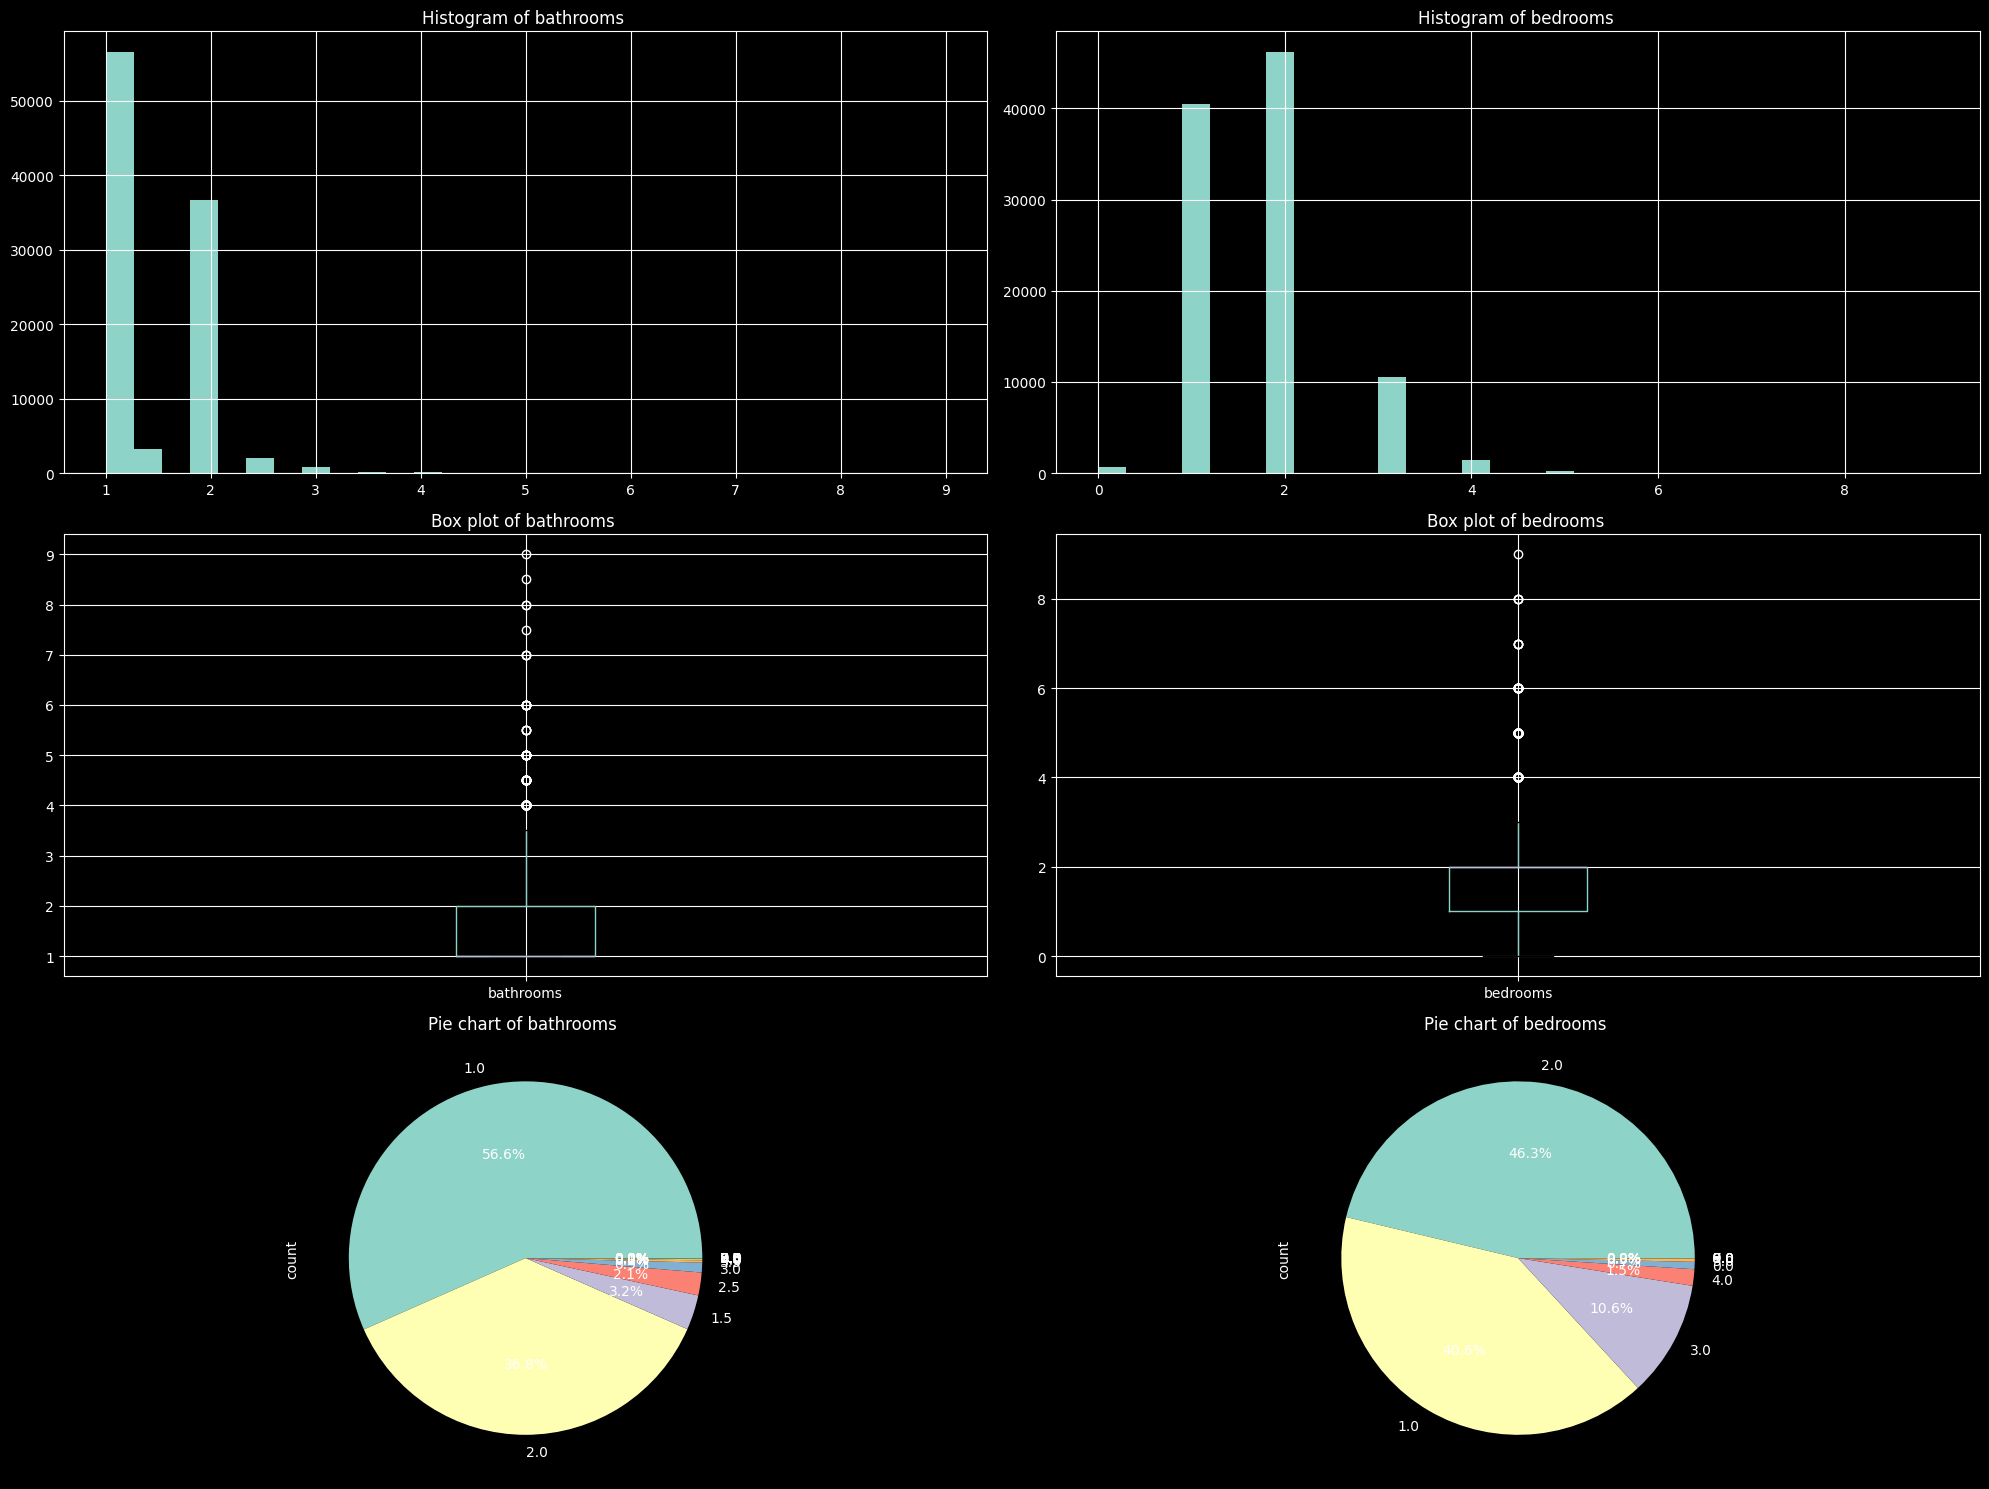

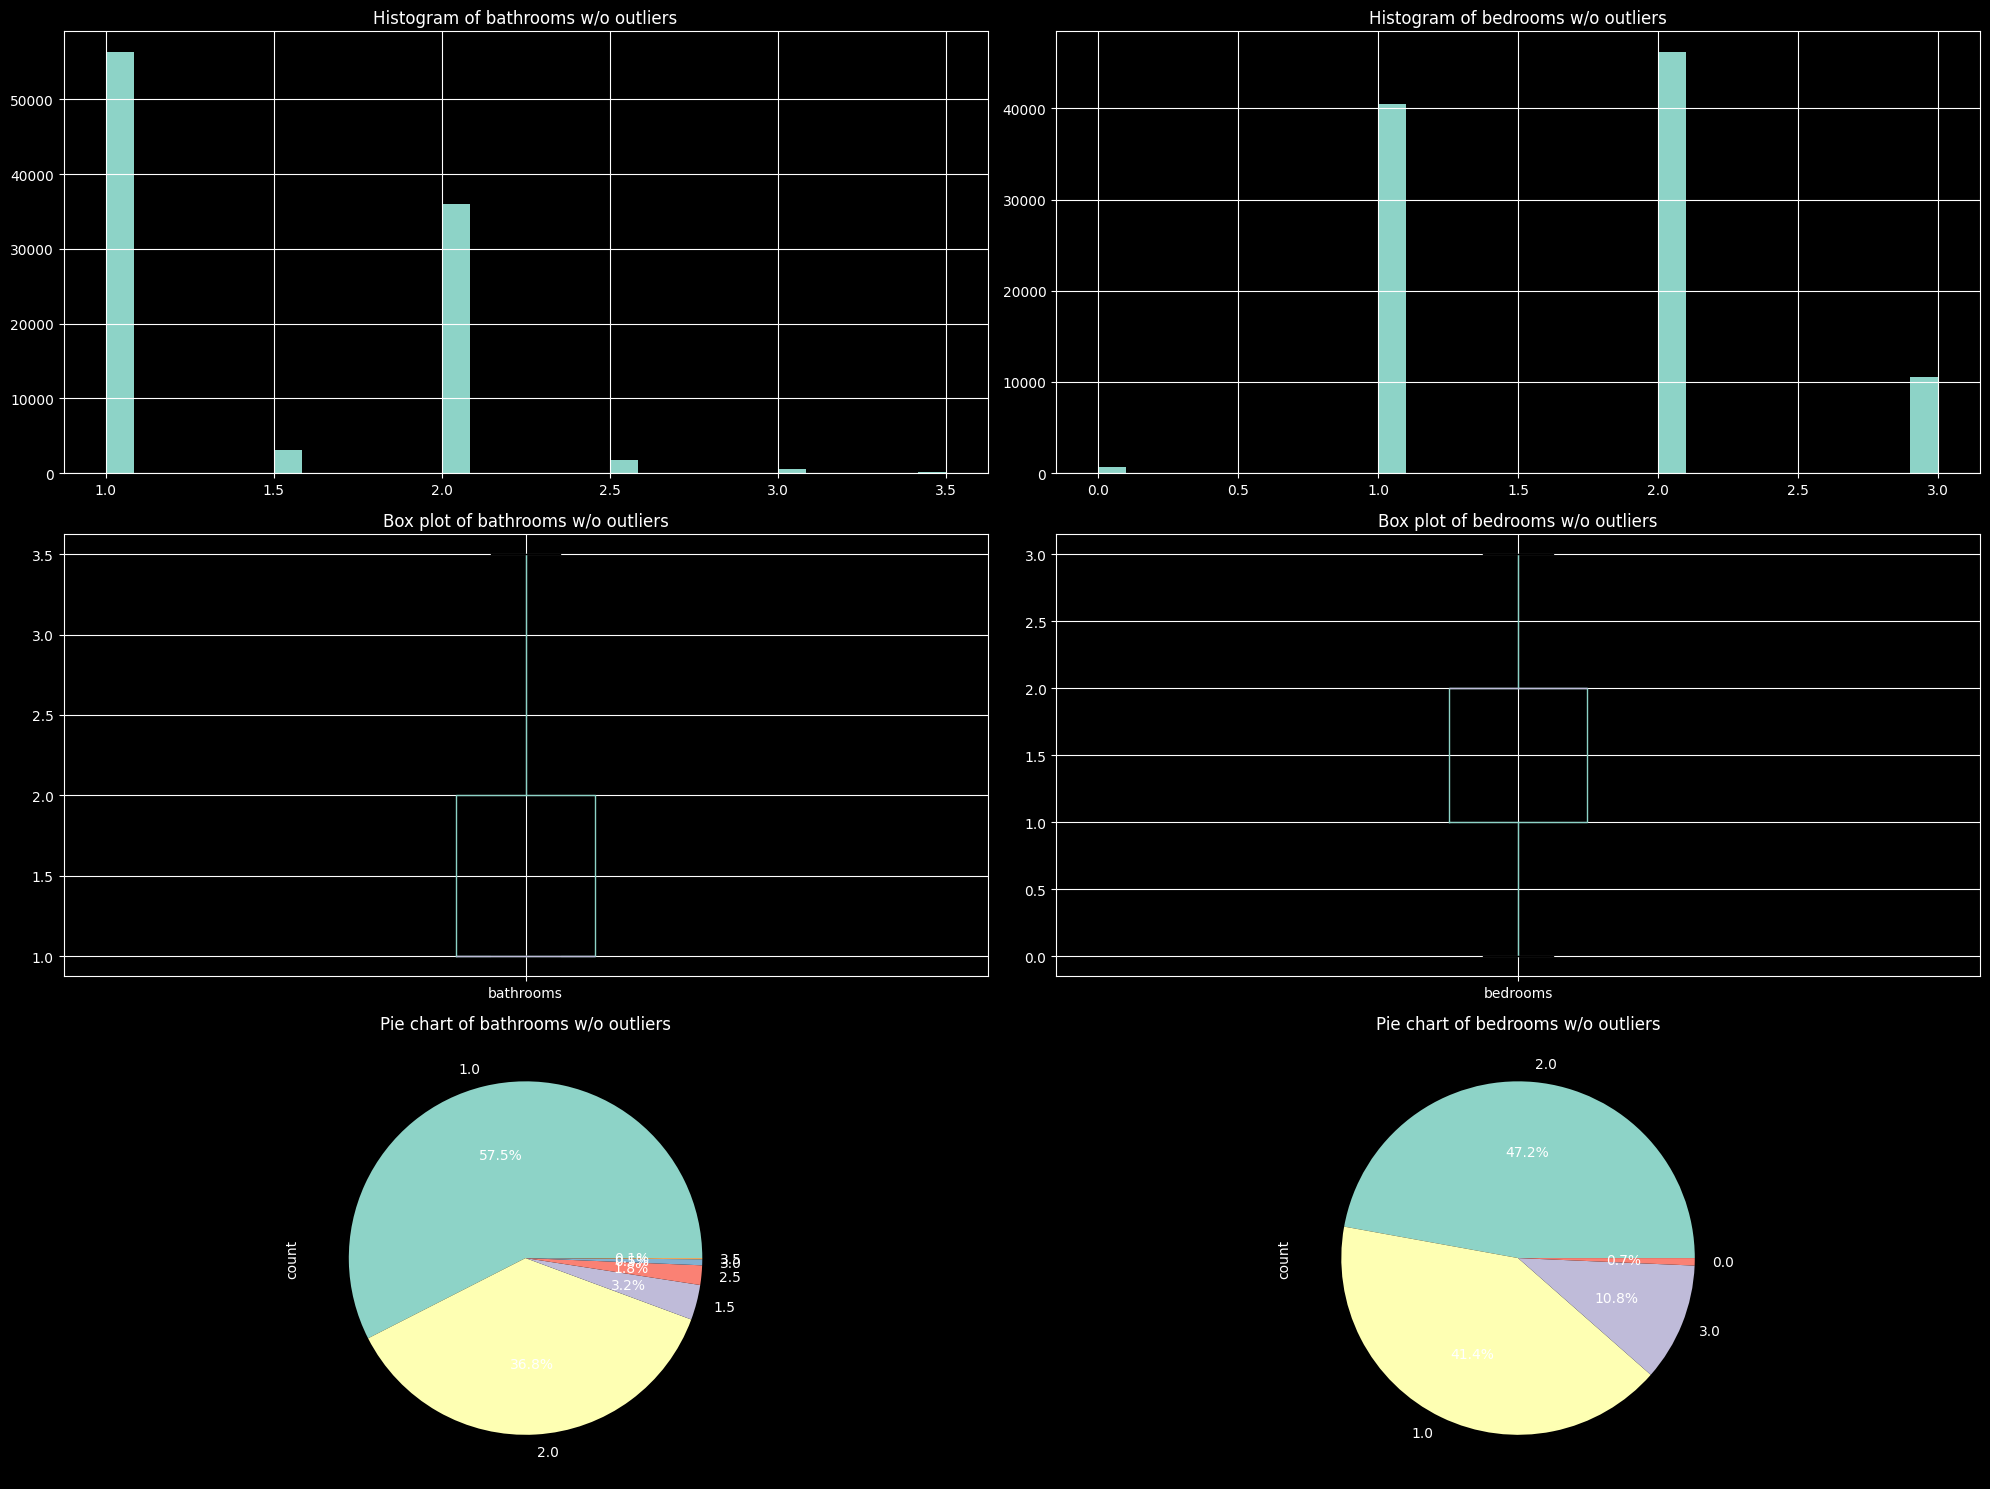

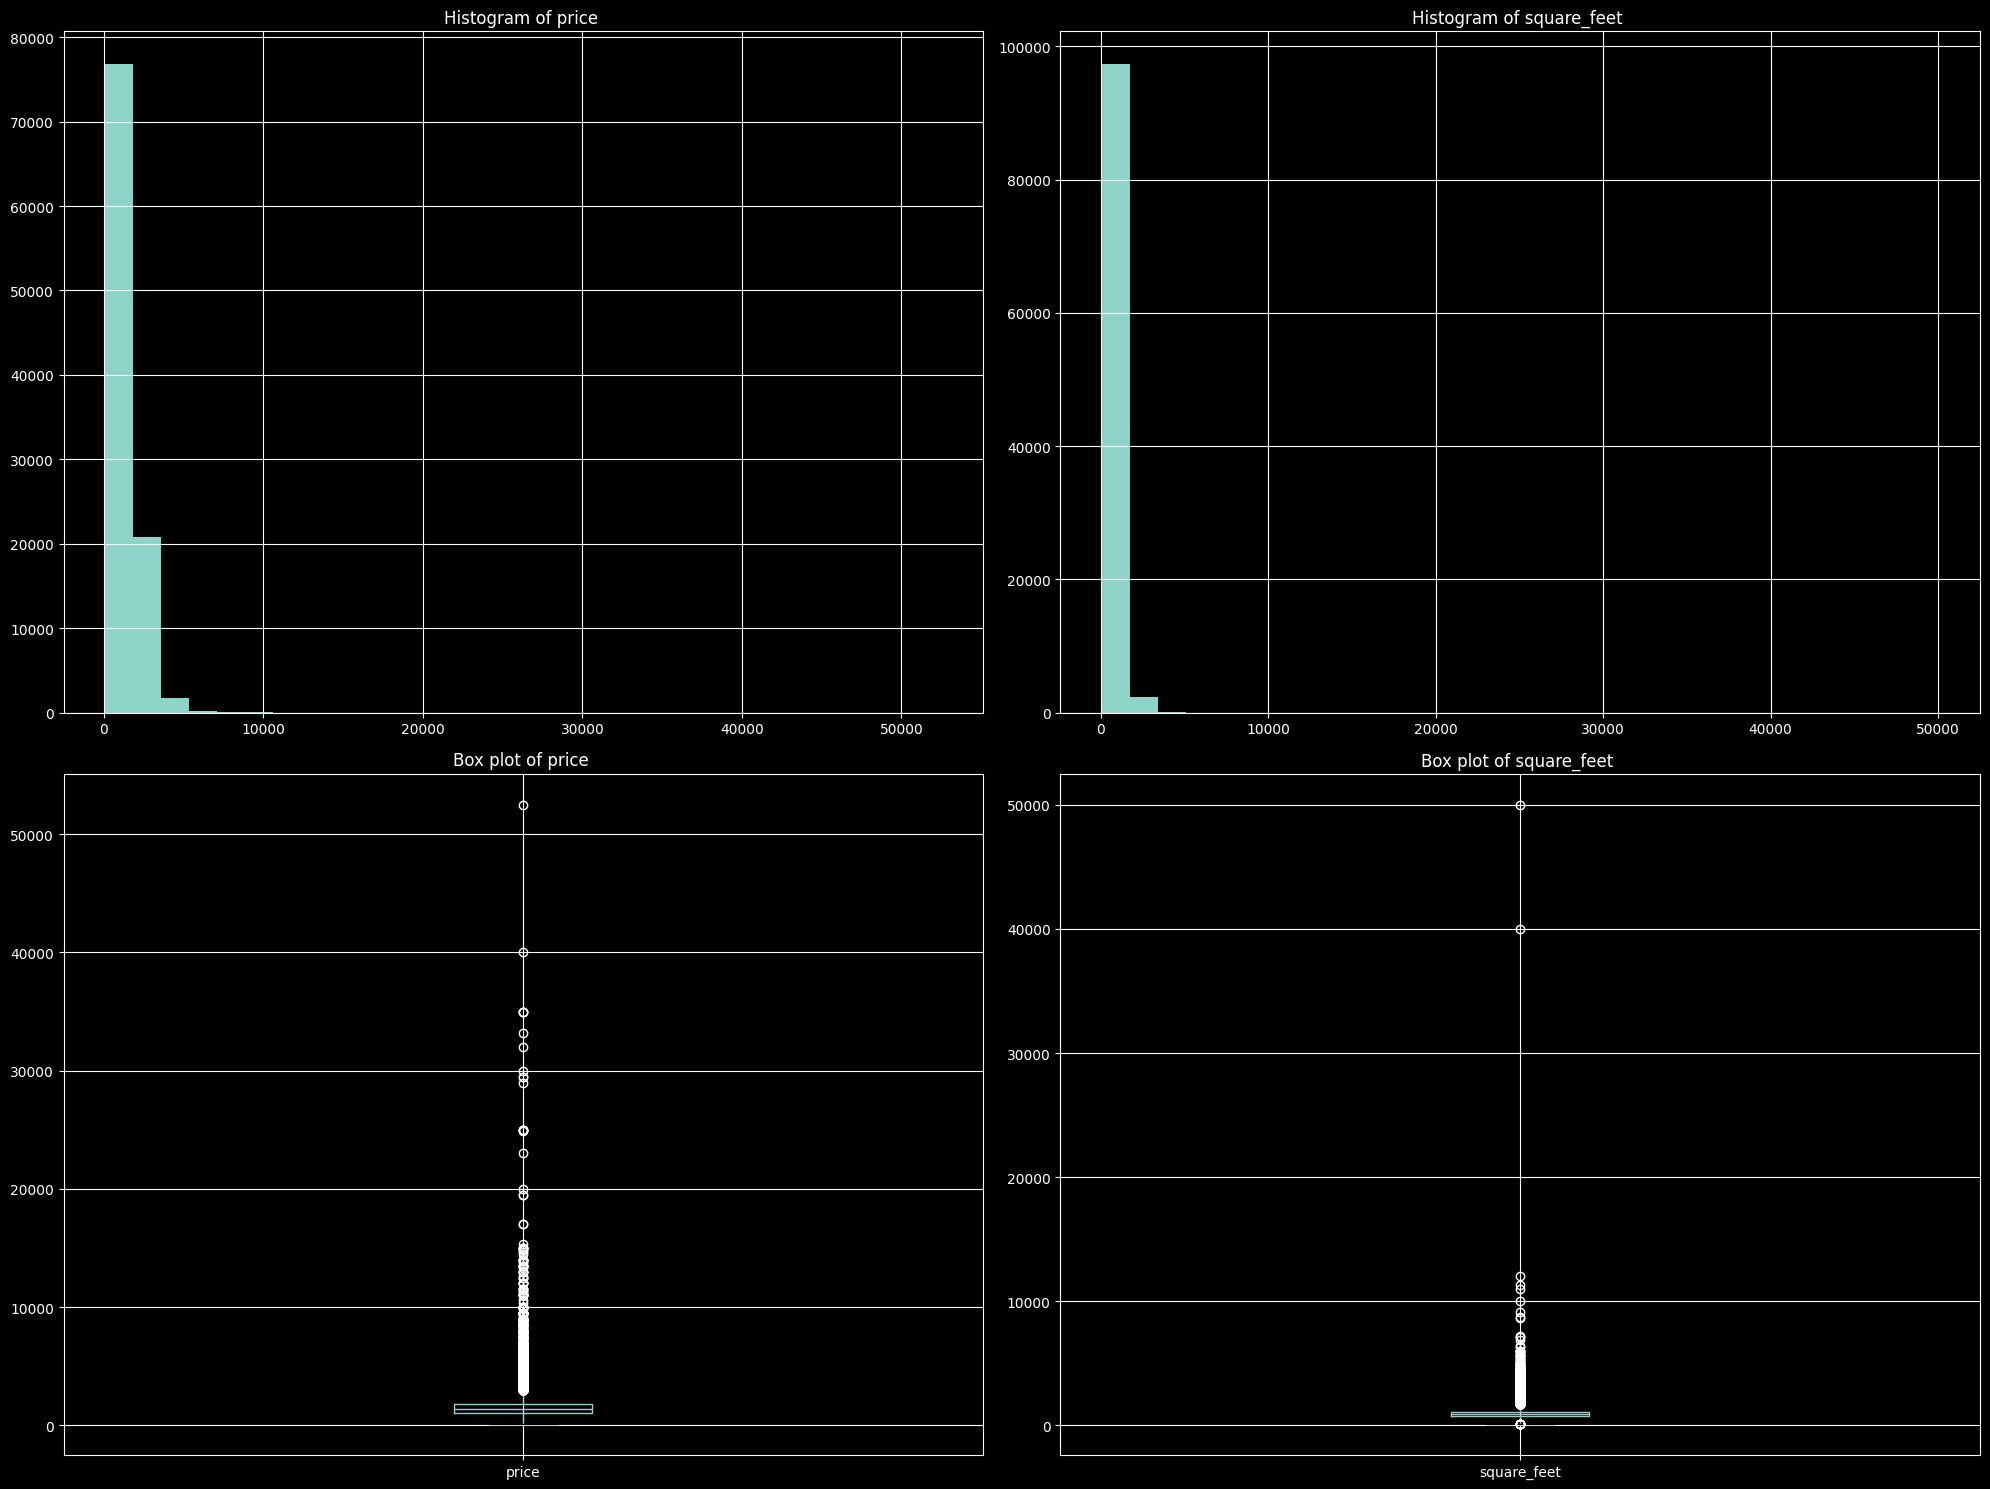

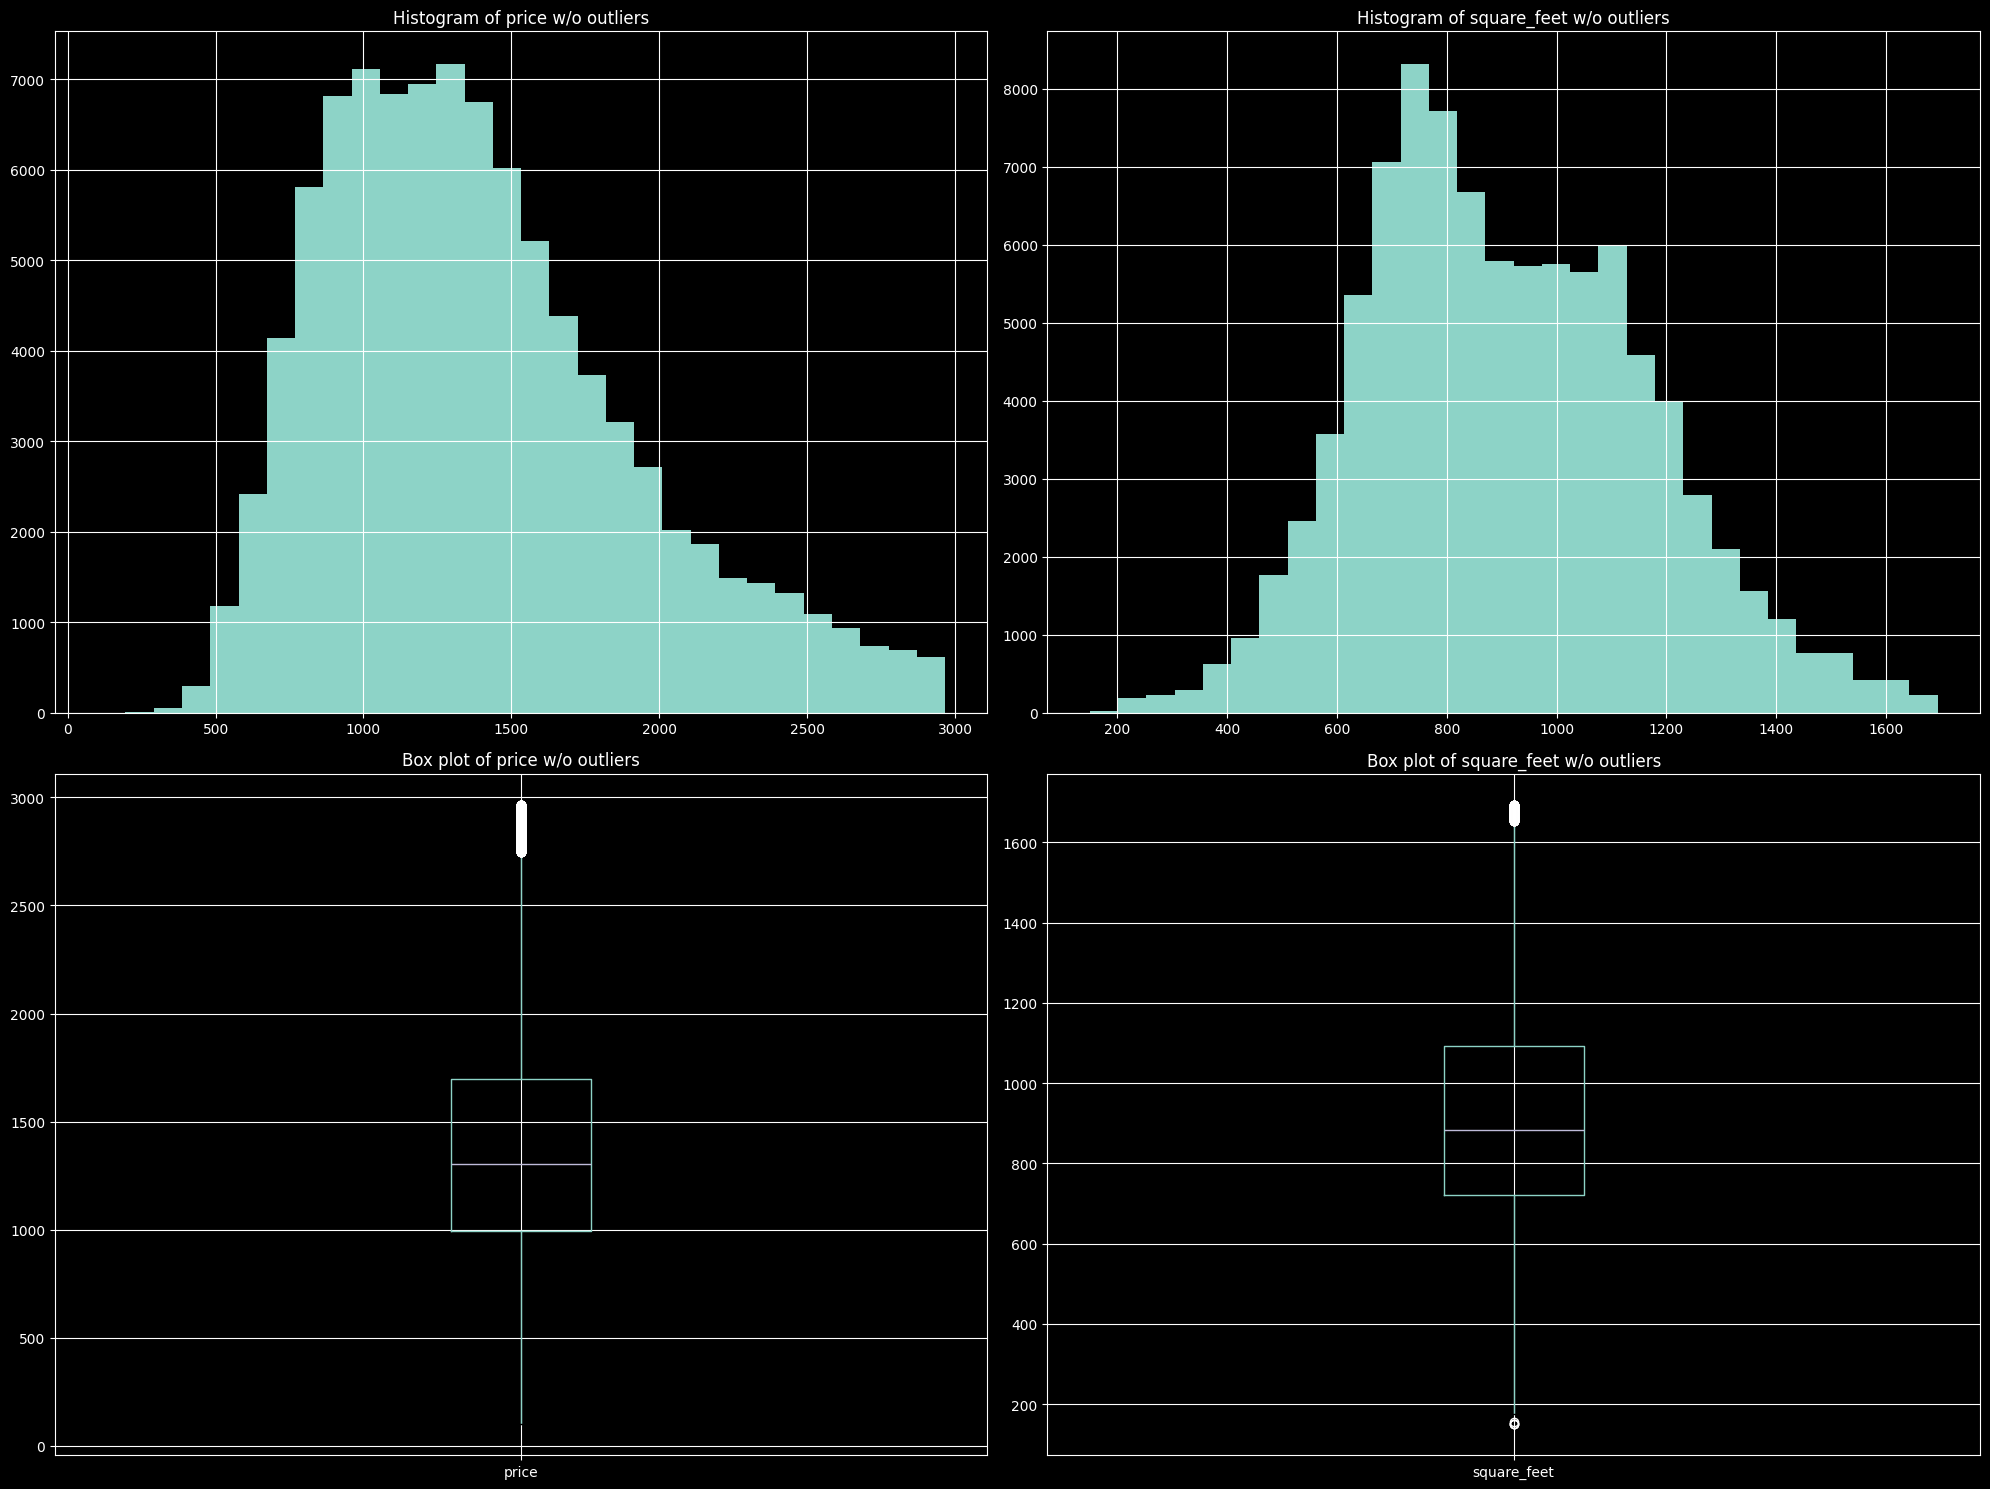

In [7]:
def remove_outliers(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    return df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

def plot(cont_feat, title = ''):
    _, axes = plt.subplots(3, 2, figsize=(20, 15))
    for i, column in enumerate(cont_feat.columns):
        row, col = divmod(i, 2)
        cont_feat[column].hist(ax=axes[row, col], bins=30)
        axes[row, col].set_title(f'Histogram of {column} {title}')
        cont_feat.boxplot(column=column, ax=axes[row + 1, col])
        axes[row + 1, col].set_title(f'Box plot of {column} {title}')
        cont_feat[column].value_counts().plot(kind='pie', ax=axes[row + 2, col], autopct='%1.1f%%')
        axes[row + 2, col].set_title(f'Pie chart of {column} {title}')
    plt.tight_layout()
    plt.show()

def plot_no_pie(cont_feat, title = ''):
    _, axes = plt.subplots(2, 2, figsize=(20, 15))
    for i, column in enumerate(cont_feat.columns):
        row, col = divmod(i, 2)
        cont_feat[column].hist(ax=axes[row, col], bins=30)
        axes[row, col].set_title(f'Histogram of {column} {title}')
        cont_feat.boxplot(column=column, ax=axes[row + 1, col])
        axes[row + 1, col].set_title(f'Box plot of {column} {title}')
    plt.tight_layout()
    plt.show()

continuous_features = continuous_features.drop(columns=['time'])
price_sqft_bath_bed = continuous_features.drop(columns=['longitude', 'latitude'])

bth_bed = price_sqft_bath_bed.drop(columns=['price', 'square_feet'])
# cont_feat = cont_feat.apply(pd.to_numeric, errors='coerce')
plot(bth_bed)
bath_bed = remove_outliers(bth_bed)
plot(bath_bed, 'w/o outliers')

cont_feat = price_sqft_bath_bed.drop(columns=['bathrooms', 'bedrooms'])
plot_no_pie(cont_feat)
price_and_sqft = remove_outliers(cont_feat)
plot_no_pie(price_and_sqft, 'w/o outliers')

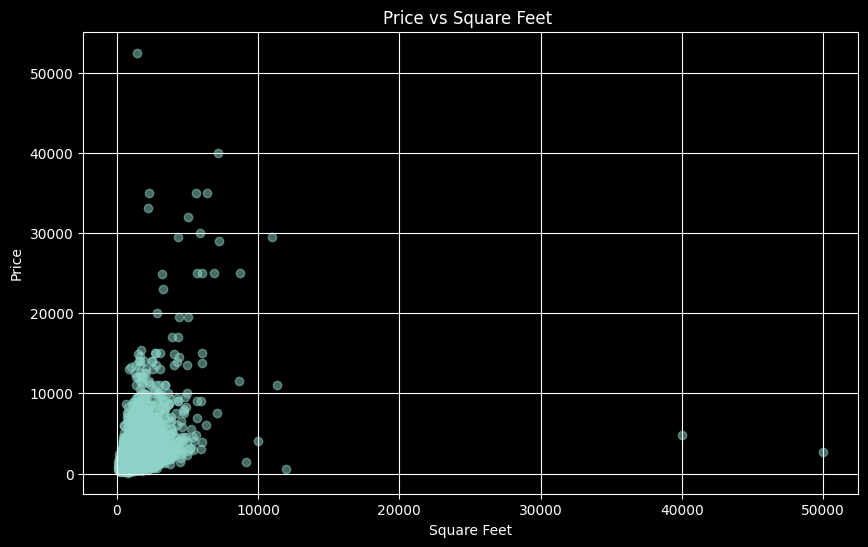

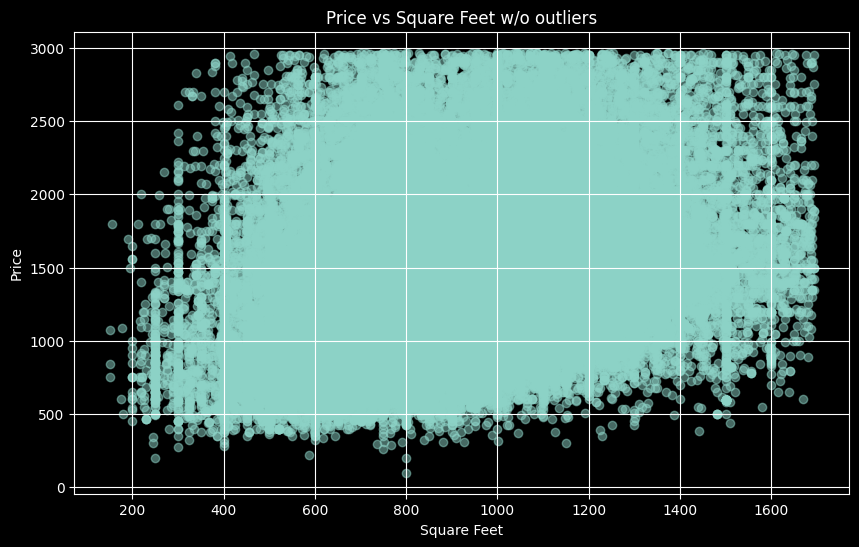

In [8]:
def plot_scatter(x, y, title = ''):
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, alpha=0.5)
    plt.title(f'Price vs Square Feet {title}')
    plt.xlabel('Square Feet')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

plot_scatter(continuous_features['square_feet'], continuous_features['price'])
plot_scatter(price_and_sqft['square_feet'], price_and_sqft['price'], 'w/o outliers')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

def split_dataset_target_price(df):
    X = df.drop(columns=['price'])
    y = df['price']
    imputer = SimpleImputer(strategy='mean')
    X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    return train_test_split(X, y, test_size=0.2, random_state=0)

In [10]:
from sklearn.model_selection import GridSearchCV

def find_best_hyperparams(param_grid, model, fit_train_features, fit_train_target):
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_absolute_error')

    grid_search.fit(fit_train_features, fit_train_target)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    results = pd.DataFrame(grid_search.cv_results_)
    params_scores = results[['params', 'mean_test_score', 'mean_score_time', 'mean_fit_time']]

    print("All Parameters and their Scores:")
    print(params_scores)
    print(f'Best Parameters: {best_params}')
    print(f'Best Score: {best_score}')
    return best_params, params_scores

In [11]:
no_latitude_longitude = continuous_features.drop(columns=['latitude', 'longitude'])

continuous_features_no_outliers = remove_outliers(continuous_features)

X_train, X_test, y_train, y_test = split_dataset_target_price(continuous_features_no_outliers)


scaler = StandardScaler()
min_max = MinMaxScaler()
# X_train_scaled = X_train
# X_test_scaled = X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import time

def calc_mae_mape(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, mape

def knn(n):
    knn = KNeighborsRegressor(n_neighbors=n)
    start_time = time.time()
    knn.fit(X_train_scaled, y_train)

    y_pred = knn.predict(X_test_scaled)
    end_time = time.time()
    time_taken = end_time - start_time
    print(f'Time taken to train and predict: {time_taken}')

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)

    mae, mape = calc_mae_mape(y_test, y_pred)

    print(f'Mean Absolute Error: {mae}')
    print(f'Mean Absolute Percentage Error: {mape}')
    print(f'Root Mean Squared Error: {rmse}')

different_n = [3, 10, 20]

for n in different_n:
    print(f'For n = {n}')
    knn(n)

best_params, param_scores = find_best_hyperparams({'n_neighbors': [3, 10, 20]}, KNeighborsRegressor(), X_train_scaled, y_train)

For n = 3
Time taken to train and predict: 0.6538999080657959
Mean Absolute Error: 184.33457727051442
Mean Absolute Percentage Error: 0.1420289001615244
Root Mean Squared Error: 280.22414705852304
For n = 10
Time taken to train and predict: 0.7558677196502686
Mean Absolute Error: 208.42345967436577
Mean Absolute Percentage Error: 0.1620124059119357
Root Mean Squared Error: 291.9482593167732
For n = 20
Time taken to train and predict: 0.684025764465332
Mean Absolute Error: 224.7788445664521
Mean Absolute Percentage Error: 0.1763836590852467
Root Mean Squared Error: 306.4962848974597
All Parameters and their Scores:
                params  mean_test_score  mean_score_time  mean_fit_time
0   {'n_neighbors': 3}        -200.0947           0.3541         0.0243
1  {'n_neighbors': 10}        -221.0061           0.4966         0.0268
2  {'n_neighbors': 20}        -234.7893           0.7958         0.0334
Best Parameters: {'n_neighbors': 3}
Best Score: -200.09467511450103


In [13]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

# param_grid = [
#     {'max_depth': 3, 'min_samples_leaf': 100, 'ccp_alpha': 0.01, 'max_features': 3},
#     {'max_depth': 5, 'min_samples_leaf': 200, 'ccp_alpha': 0.005, 'max_features': 3},
#     {'max_depth': 7, 'min_samples_leaf': 500, 'ccp_alpha': 0.001, 'max_features': 3}
# ]


param_grid = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [100, 200, 500],
    'ccp_alpha': [0.01],
    'max_features': [3]
}

best_params, param_scores = find_best_hyperparams(param_grid, DecisionTreeRegressor(random_state=0), X_train_scaled, y_train)


results = []

# for params in param_grid:
#     dt_regressor = DecisionTreeRegressor(random_state=0, **params)

#     start_time = time.time()
#     dt_regressor.fit(X_train_scaled, y_train)

#     # plt.figure(figsize=(20, 10))
#     # plot_tree(dt_regressor, feature_names=X_train.columns, filled=True)
#     # plt.title(f"Decision Tree with params: {params}")
#     # plt.show()

#     y_pred = dt_regressor.predict(X_test_scaled)
#     end_time = time.time()
#     time_taken = end_time - start_time
#     print(f'Time taken to train and predict: {time_taken}')

#     mae, mape = calc_mae_mape(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#     results.append({'params': params, 'mae': mae, 'mape': mape, 'rmse': rmse})

#     print(f"Params: {params}")
#     print(f'Decision Tree Mean Absolute Error: {mae}')
#     print(f'Decision Tree Root Mean Square Error: {rmse}')
#     print(f'Decision Tree Mean Absolute Percentage Error: {mape}')

# results = pd.DataFrame(results)


All Parameters and their Scores:
                                              params  mean_test_score  \
0  {'ccp_alpha': 0.01, 'max_depth': 3, 'max_featu...        -320.0290   
1  {'ccp_alpha': 0.01, 'max_depth': 3, 'max_featu...        -320.0290   
2  {'ccp_alpha': 0.01, 'max_depth': 3, 'max_featu...        -320.0290   
3  {'ccp_alpha': 0.01, 'max_depth': 5, 'max_featu...        -290.0284   
4  {'ccp_alpha': 0.01, 'max_depth': 5, 'max_featu...        -290.0504   
5  {'ccp_alpha': 0.01, 'max_depth': 5, 'max_featu...        -289.7288   
6  {'ccp_alpha': 0.01, 'max_depth': 7, 'max_featu...        -263.1217   
7  {'ccp_alpha': 0.01, 'max_depth': 7, 'max_featu...        -265.8092   
8  {'ccp_alpha': 0.01, 'max_depth': 7, 'max_featu...        -272.5519   

   mean_score_time  mean_fit_time  
0           0.0022         0.0292  
1           0.0016         0.0272  
2           0.0017         0.0259  
3           0.0020         0.0375  
4           0.0022         0.0387  
5           0.0016  

In [14]:
from sklearn.ensemble import RandomForestRegressor

# JASKDBFJKASDBFHJASDBFJKADSBFJBADSJKFBADSFJASBDFJASBFJKHLASBDFJKASDBFJASBFJKASBFASBDFJKADSBF
param_grid = [
    {'min_samples_leaf': 100, 'n_estimators': 25},
    {'min_samples_leaf': 200, 'n_estimators': 50},
    {'min_samples_leaf': 500, 'n_estimators': 100}
]

param_grid = {
    'min_samples_leaf': [100, 200, 500],
    'n_estimators': [25, 50, 100]
}

best_params, param_scores = find_best_hyperparams(param_grid, RandomForestRegressor(random_state=0, max_features=3), X_train_scaled, y_train)

# results = []

# for params in param_grid:
#     rf_regressor = RandomForestRegressor(random_state=0, max_features=3, **params)

#     start_time = time.time()
#     rf_regressor.fit(X_train_scaled, y_train)

#     y_pred = rf_regressor.predict(X_test_scaled)
#     end_time = time.time()
#     time_taken = end_time - start_time
#     print(f'Time taken to train and predict: {time_taken}')

#     mae, mape = calc_mae_mape(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#     results.append({'params': params, 'mae': mae, 'mape': mape, 'rmse': rmse, 'time': time_taken})

#     print(f"Params: {params}")
#     print(f'Random Forest Mean Absolute Error: {mae}')
#     print(f'Random Forest Root Mean Square Error: {rmse}')
#     print(f'Random Forest Mean Absolute Percentage Error: {mape}')

# results = pd.DataFrame(results)

All Parameters and their Scores:
                                           params  mean_test_score  \
0   {'min_samples_leaf': 100, 'n_estimators': 25}        -222.4785   
1   {'min_samples_leaf': 100, 'n_estimators': 50}        -221.8588   
2  {'min_samples_leaf': 100, 'n_estimators': 100}        -221.6276   
3   {'min_samples_leaf': 200, 'n_estimators': 25}        -238.4907   
4   {'min_samples_leaf': 200, 'n_estimators': 50}        -237.8780   
5  {'min_samples_leaf': 200, 'n_estimators': 100}        -237.4565   
6   {'min_samples_leaf': 500, 'n_estimators': 25}        -262.6451   
7   {'min_samples_leaf': 500, 'n_estimators': 50}        -262.0443   
8  {'min_samples_leaf': 500, 'n_estimators': 100}        -261.6465   

   mean_score_time  mean_fit_time  
0           0.0487         1.0773  
1           0.0866         1.9762  
2           0.1839         4.0384  
3           0.0444         0.8141  
4           0.0842         2.0383  
5           0.2065         3.5880  
6           0.

In [15]:
from sklearn.neural_network import MLPRegressor

# Define the parameter grid for MLPRegressor
param_grid = {
    'hidden_layer_sizes': [(20, 10), (30, 15), (10, 5)],
    'learning_rate_init': [0.01, 0.001],
    'activation': ['relu', 'tanh']
}

best_params, param_scores = find_best_hyperparams(param_grid, MLPRegressor(random_state=0), X_train_scaled, y_train)



# param_grid = [
#     {'hidden_layer_sizes': (20, 10), 'learning_rate_init': 0.01, 'activation': 'relu'},
#     {'hidden_layer_sizes': (30, 15), 'learning_rate_init': 0.001, 'activation': 'relu'},
#     {'hidden_layer_sizes': (10, 5), 'learning_rate_init': 0.01, 'activation': 'tanh'}
# ]



# result = []

# for params in param_grid:
#     mlp_regressor = MLPRegressor(random_state=0, **params)

#     start_time = time.time()
#     mlp_regressor.fit(X_train_scaled, y_train)

#     y_pred = mlp_regressor.predict(X_test_scaled)
#     end_time = time.time()
#     time_taken = end_time - start_time
#     print(f'Time taken to train and predict: {time_taken}')

#     mae, mape = calc_mae_mape(y_test, y_pred)
#     rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#     print(f"Params: {params}")
#     print(f'MLP Mean Absolute Error: {mae}')
#     print(f'MLP Root Mean Square Error: {rmse}')
#     print(f'MLP Mean Absolute Percentage Error: {mape}')
#     result.append({'params': params, 'mae': mae, 'mape': mape, 'rmse': rmse, 'time': time_taken})

# result = pd.DataFrame(result)

# best_params, param_scores = find_best_hyperparams(param_grid, MLPRegressor(random_state=0), X_train_scaled, y_train)

/Users/p997bjd/uniproj/ai/lab1/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/p997bjd/uniproj/ai/lab1/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/p997bjd/uniproj/ai/lab1/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/p997bjd/uniproj/ai/lab1/venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
 

All Parameters and their Scores:
                                               params  mean_test_score  \
0   {'activation': 'relu', 'hidden_layer_sizes': (...        -264.6262   
1   {'activation': 'relu', 'hidden_layer_sizes': (...        -293.6835   
2   {'activation': 'relu', 'hidden_layer_sizes': (...        -260.3711   
3   {'activation': 'relu', 'hidden_layer_sizes': (...        -276.5713   
4   {'activation': 'relu', 'hidden_layer_sizes': (...        -277.8496   
5   {'activation': 'relu', 'hidden_layer_sizes': (...        -310.3784   
6   {'activation': 'tanh', 'hidden_layer_sizes': (...        -417.2272   
7   {'activation': 'tanh', 'hidden_layer_sizes': (...        -849.0103   
8   {'activation': 'tanh', 'hidden_layer_sizes': (...        -417.1608   
9   {'activation': 'tanh', 'hidden_layer_sizes': (...        -629.9213   
10  {'activation': 'tanh', 'hidden_layer_sizes': (...        -371.0852   
11  {'activation': 'tanh', 'hidden_layer_sizes': (...       -1092.4734   

    